# Optimal Path under Distance Minimzation + Satellite Coverage

Person 1: (4, 17) -> (83, 90) | steps=152, points=431
Person 2: (10, 10) -> (90, 10) | steps=80, points=50
Person 3: (20, 80) -> (75, 25) | steps=110, points=228


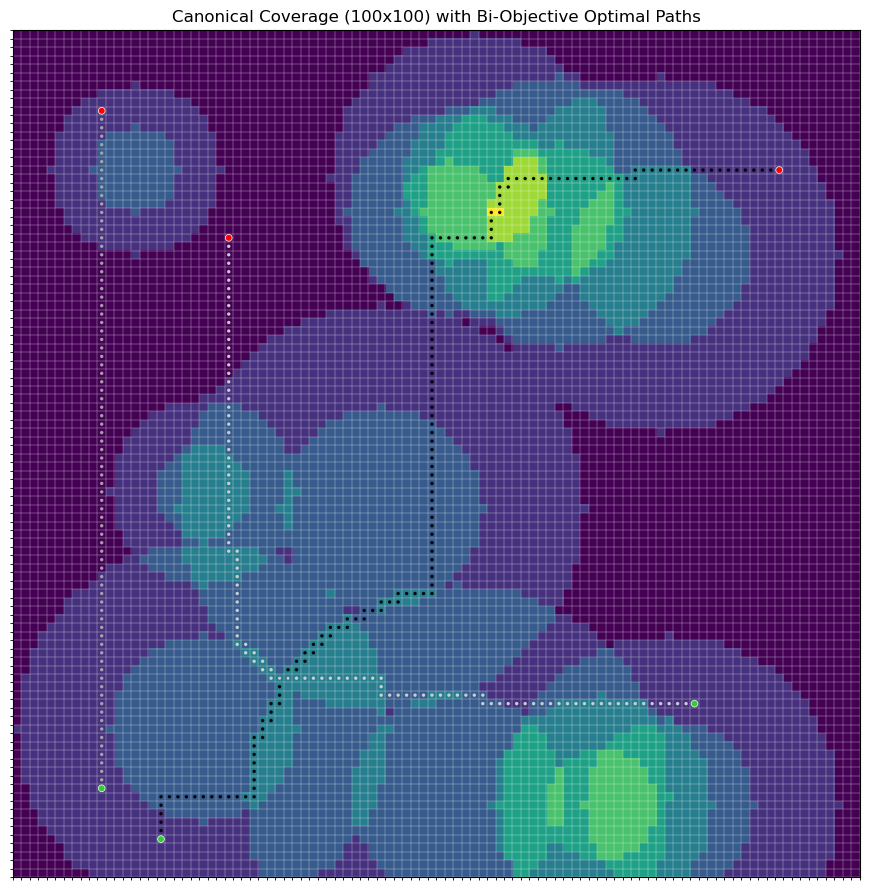

In [21]:
# ================================================================
# Full script: Grid coverage + multi-objective BFS pathfinding
# ================================================================
# 1. Satellites create additive "coverage strength" across a grid
# 2. People move from start -> end; we find the path that:
#       - uses the FEWEST steps (shortest path)
#       - among those shortest paths, collects the MOST points
# 3. We then visualize everything on a heat map
# ================================================================

from typing import List, Tuple           # For clean type hints
from collections import deque            # BFS queue
import numpy as np                       # Fast arrays for the grid
import matplotlib.pyplot as plt          # Plotting the heat map
from matplotlib.patches import Circle    # To draw circles for start, end, path

# ----------------------------
# Type aliases (for readability)
Satellite = Tuple[Tuple[int, int], int]      # e.g., ((row, col), radius)
Person    = Tuple[Tuple[int, int], Tuple[int, int]]  # (start_rc, end_rc)

# ----------------------------
# Fixed satellites. Each is (position, radius).
# These create the coverage "terrain" of the grid.
SATELLITES: List[Satellite] = [
    ((8, 77), 20),
    ((43, 43), 24),
    ((8, 69), 13),
    ((9, 52), 25),
    ((73, 76), 21),
    ((78, 51), 12),
    ((78, 64), 16),
    ((82, 54), 17),
    ((45, 22), 11),
    ((83, 14), 10),
    ((17, 22), 22),
]

# ----------------------------
# Build coverage grid
# - Start with zeros (no coverage)
# - For each satellite, loop over a bounding box around its circle
# - If a cell is inside the radius, add +1
# - If also inside half the radius, add +1 more (so center is stronger)
def build_coverage(satellites: List[Satellite], rows: int = 100, cols: int = 100) -> np.ndarray:
    # Initialize a rows x cols grid of zeros
    C = np.zeros((rows, cols), dtype=np.int32)

    for (tr, tc), R in satellites:   # tr=row, tc=col, R=radius
        # Restrict loop to square bounding the circle (optimization)
        r0, r1 = max(0, tr - R), min(rows - 1, tr + R)
        c0, c1 = max(0, tc - R), min(cols - 1, tc + R)

        # Precompute squared distances for comparisons
        halfR2 = (0.5 * R) ** 2
        R2 = R * R

        # Loop over candidate rows
        for r in range(r0, r1 + 1):
            dr2 = (r - tr) * (r - tr)  # vertical squared distance
            # Loop over candidate cols
            for c in range(c0, c1 + 1):
                d2 = dr2 + (c - tc) * (c - tc)  # total squared distance
                if d2 <= R2:        # inside full radius
                    C[r, c] += 1
                    if d2 <= halfR2: # inside half radius
                        C[r, c] += 1
    return C

# ----------------------------
# BFS to find optimal path
# Goal: shortest path. Tie-breaker: highest coverage points collected.
def optimal_path(grid: np.ndarray, start: Tuple[int,int], end: Tuple[int,int]) -> Tuple[int,int,List[Tuple[int,int]]]:
    rows, cols = grid.shape
    # Quick helper to check grid bounds
    inb = lambda r, c: 0 <= r < rows and 0 <= c < cols

    # best[r][c] holds the best-known (steps, points) when reaching (r,c)
    # None means not visited yet
    best = [[None] * cols for _ in range(rows)]
    best[start[0]][start[1]] = (0, int(grid[start[0], start[1]]))

    # Queue stores: (row, col, distance_so_far, points_so_far, path_so_far)
    q = deque([(start[0], start[1], 0, int(grid[start[0], start[1]]), [start])])

    best_path = None
    best_points = -1

    while q:
        r, c, dist, pts, path = q.popleft()  # BFS pops from left
        '''
        .pop()      -> removes & returns LAST item (stack/LIFO behavior)  
        .pop(0)     -> removes & returns FIRST item (slow for lists; O(n))  
        .popleft()  -> removes & returns FIRST item from deque (fast; O(1))  
        - Use .pop()   if you want DFS (last-in, first-out search order)  
        - Use .popleft() if you want BFS (first-in, first-out search order)  
        '''

        # If we've reached the end cell
        if (r, c) == end:
            # Accept path if:
            # - First path found, OR
            # - Fewer steps than previous best, OR
            # - Equal steps but higher points
            if (best_path is None
                or dist < len(best_path) - 1
                or (dist == len(best_path) - 1 and pts > best_points)):
                best_path = path
                best_points = pts
            continue

        # Explore 4-connected neighbors
        for nr, nc in ((r+1, c), (r-1, c), (r, c+1), (r, c-1)):
            if inb(nr, nc):
                new_dist = dist + 1
                new_pts  = pts + int(grid[nr, nc])
                cur = best[nr][nc]

                # Only proceed if:
                # - Never visited before, OR
                # - Found shorter path, OR
                # - Found equal-length path but with more points
                if cur is None or new_dist < cur[0] or (new_dist == cur[0] and new_pts > cur[1]):
                    best[nr][nc] = (new_dist, new_pts)
                    q.append((nr, nc, new_dist, new_pts, path + [(nr, nc)]))

    # Return tuple (steps, points, path)
    return (len(best_path) - 1, best_points, best_path) if best_path else (-1, -1, [])

# ----------------------------
# Four people (start -> end)
# Each will run BFS independently
PEOPLE: List[Person] = [
    ((4, 17), (83, 90)),
    ((10, 10), (90, 10)),
    ((20, 80), (75, 25))
]

# ----------------------------
# Visualization
# - Heat map from coverage
# - Paths drawn as small dots
# - Starts in green, ends in red
def plot_people_paths(C: np.ndarray, people: List[Person], title: str) -> None:
    rows, cols = C.shape
    fig, ax = plt.subplots(figsize=(9, 9))

    # Heat map background
    ax.imshow(C, origin='lower', interpolation='nearest')

    # White grid lines (thin)
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.2)
    ax.set_xticks([]); ax.set_yticks([])

    # Marker sizes
    r_start_end = 0.4   # big circles for start/end
    r_path = 0.2        # small dots for path

    # Colors (rotates if more people than colors)
    path_colors = ["black", "darkgray", "lightgray", "silver"]

    # Loop over each person
    for i, (start, end) in enumerate(people):
        steps, points, path = optimal_path(C, start, end)
        color = path_colors[i % len(path_colors)]

        # Draw path dots (skip first/last to avoid overlap with start/end markers)
        for (rr, cc) in (path[1:-1] if path and len(path) > 2 else []):
            ax.add_patch(Circle((cc, rr), r_path, facecolor=color, edgecolor="none", alpha=0.95))

        # Draw start marker (green)
        ax.add_patch(Circle((start[1], start[0]), r_start_end,
                            facecolor="limegreen", edgecolor="white", linewidth=0.5))

        # Draw end marker (red)
        ax.add_patch(Circle((end[1], end[0]), r_start_end,
                            facecolor="red", edgecolor="white", linewidth=0.5))

        # Print summary
        print(f"Person {i+1}: {start} -> {end} | steps={steps}, points={points}")

    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# ----------------------------
# Build coverage + plot paths
C = build_coverage(SATELLITES, rows=100, cols=100)
plot_people_paths(C, PEOPLE, title="Canonical Coverage (100x100) with Bi-Objective Optimal Paths")


# Sparse
---
### (no comments)

In [24]:
from typing import List, Tuple
from collections import deque
import numpy as np

Satellite = Tuple[Tuple[int, int], int]
Person = Tuple[Tuple[int, int], Tuple[int, int]]

SATELLITES: List[Satellite] = [
    ((8, 77), 20),
    ((43, 43), 24),
    ((8, 69), 13)
]

PEOPLE: List[Person] = [
    ((4, 17), (83, 90)),
    ((10, 50), (90, 10))
]

def build_coverage(satellites: List[Satellite], rows: int = 100, cols: int = 100) -> np.ndarray:
    C = np.zeros((rows, cols), dtype=np.int32)
    for (tr, tc), R in satellites:
        r0, r1 = max(0, tr - R), min(rows - 1, tr + R)
        c0, c1 = max(0, tc - R), min(cols - 1, tc + R)
        halfR2 = (0.5 * R) ** 2
        R2 = R * R
        for r in range(r0, r1 + 1):
            dr2 = (r - tr) * (r - tr)
            for c in range(c0, c1 + 1):
                d2 = dr2 + (c - tc) * (c - tc)
                if d2 <= R2:
                    C[r, c] += 1
                    if d2 <= halfR2:
                        C[r, c] += 1
    return C

def optimal_path(grid: np.ndarray, start: Tuple[int,int], end: Tuple[int,int]) -> Tuple[int,int,List[Tuple[int,int]]]:
    rows, cols = grid.shape
    inb = lambda r, c: 0 <= r < rows and 0 <= c < cols
    best = [[None] * cols for _ in range(rows)]
    best[start[0]][start[1]] = (0, int(grid[start[0], start[1]]))
    q = deque([(start[0], start[1], 0, int(grid[start[0], start[1]]), [start])])
    best_path = None
    best_points = -1
    while q:
        r, c, dist, pts, path = q.popleft()
        if (r, c) == end:
            if (best_path is None
                or dist < len(best_path) - 1
                or (dist == len(best_path) - 1 and pts > best_points)):
                best_path = path
                best_points = pts
            continue
        for nr, nc in ((r+1, c), (r-1, c), (r, c+1), (r, c-1)):
            if inb(nr, nc):
                new_dist = dist + 1
                new_pts  = pts + int(grid[nr, nc])
                cur = best[nr][nc]
                if cur is None or new_dist < cur[0] or (new_dist == cur[0] and new_pts > cur[1]):
                    best[nr][nc] = (new_dist, new_pts)
                    q.append((nr, nc, new_dist, new_pts, path + [(nr, nc)]))
    return (len(best_path) - 1, best_points, best_path) if best_path else (-1, -1, [])

if __name__ == "__main__":
    C = build_coverage(SATELLITES, rows=100, cols=100)
    for i, (start, end) in enumerate(PEOPLE):
        steps, points, path = optimal_path(C, start, end)
        print(f"Person {i+1}: {start} -> {end} | steps={steps}, points={points}")


Person 1: (4, 17) -> (83, 90) | steps=152, points=134
Person 2: (10, 50) -> (90, 10) | steps=120, points=96


## Paths not graphed

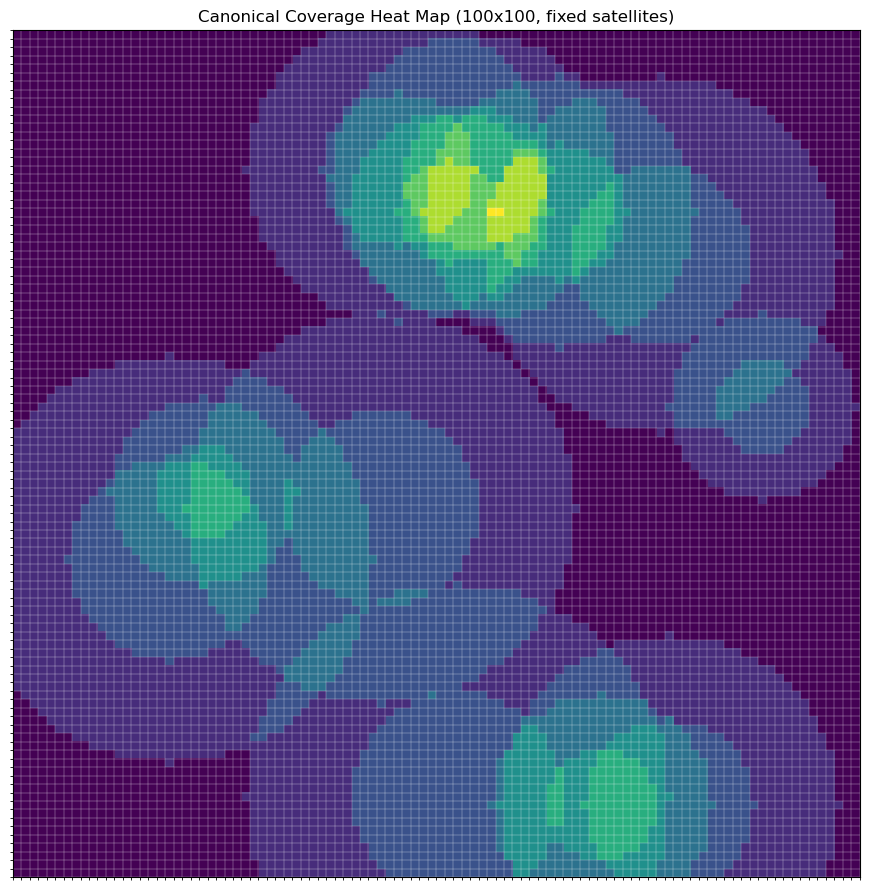

Person 1: (4, 17) -> (83, 90) | steps=152, points=465
Person 2: (10, 10) -> (90, 10) | steps=80, points=62
Person 3: (20, 80) -> (75, 25) | steps=110, points=264
Person 4: (5, 95) -> (95, 5) | steps=180, points=476


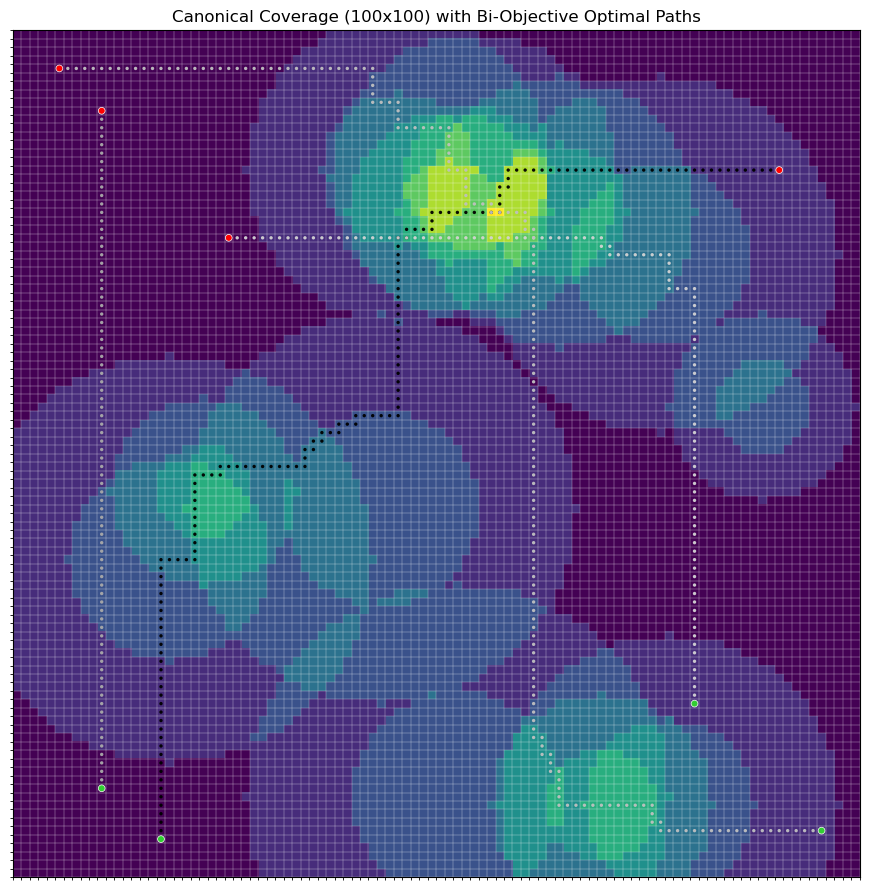

Person from (4, 17) -> (83, 90): 152 steps, 465 points
Person from (10, 10) -> (90, 10): 80 steps, 62 points
Person from (20, 80) -> (75, 25): 110 steps, 264 points
Person from (5, 95) -> (95, 5): 180 steps, 476 points


In [20]:
# Canonical satellites passed directly (no RNG)
from collections import deque
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt

Satellite = Tuple[Tuple[int, int], int]

# Directly specified satellite list
SATELLITES: List[Satellite] = [
    ((8, 77), 20),
    ((43, 43), 23),
    ((8, 69), 13),
    ((9, 52), 25),
    ((73, 76), 21),
    ((78, 51), 12),
    ((83, 45), 18),
    ((37, 18), 24),
    ((78, 64), 16),
    ((82, 54), 17),
    ((45, 22), 11),
    ((55, 88), 11)
]

def build_coverage(satellites: List[Satellite], rows: int = 100, cols: int = 100) -> np.ndarray:
    C = np.zeros((rows, cols), dtype=np.int32)
    for (tr, tc), R in satellites:
        r0, r1 = max(0, tr - R), min(rows - 1, tr + R)
        c0, c1 = max(0, tc - R), min(cols - 1, tc + R)
        halfR2 = (0.5 * R) ** 2
        R2 = R * R
        for r in range(r0, r1 + 1):
            dr2 = (r - tr) * (r - tr)
            for c in range(c0, c1 + 1):
                d2 = dr2 + (c - tc) * (c - tc)
                if d2 <= R2:
                    C[r, c] += 1
                    if d2 <= halfR2:
                        C[r, c] += 1
    return C

def plot_coverage(C: np.ndarray, title: str = "Coverage Heat Map (no path)") -> None:
    rows, cols = C.shape
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(C, origin='lower', interpolation='nearest')
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.2)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Build and plot the canonical coverage map
C = build_coverage(SATELLITES, rows=100, cols=100)
plot_coverage(C, title="Canonical Coverage Heat Map (100x100, fixed satellites)")

# People: list of (start, end) coordinates
PEOPLE: List[Tuple[Tuple[int,int], Tuple[int,int]]] = [
    ((4, 17), (83, 90)),
    ((10, 10), (90, 10)),
    ((20, 80), (75, 25)),
    ((5, 95), (95, 5))
]

def optimal_path(grid: np.ndarray, start: Tuple[int,int], end: Tuple[int,int]) -> Tuple[int,int,List[Tuple[int,int]]]:
    rows, cols = grid.shape
    inb = lambda r, c: 0 <= r < rows and 0 <= c < cols
    
    # best[r][c] = (min_dist, max_points_at_that_dist)
    best = [[None]*cols for _ in range(rows)]
    best[start[0]][start[1]] = (0, int(grid[start[0], start[1]]))
    
    q = deque([(start[0], start[1], 0, int(grid[start[0], start[1]]), [start])])
    
    best_path = None
    best_points = -1
    
    while q:
        r, c, dist, pts, path = q.popleft()
        if (r, c) == end:
            if best_path is None or dist < len(best_path)-1 or (dist == len(best_path)-1 and pts > best_points):
                best_path = path
                best_points = pts
            continue
        
        for nr, nc in ((r+1,c), (r-1,c), (r,c+1), (r,c-1)):
            if inb(nr,nc):
                new_dist = dist + 1
                new_pts = pts + int(grid[nr,nc])
                if best[nr][nc] is None or new_dist < best[nr][nc][0] or (new_dist == best[nr][nc][0] and new_pts > best[nr][nc][1]):
                    best[nr][nc] = (new_dist, new_pts)
                    q.append((nr,nc,new_dist,new_pts,path+[(nr,nc)]))
    
    if best_path:
        return len(best_path)-1, best_points, best_path
    else:
        return -1, -1, []

# Now plot again
plot_people_paths(C, PEOPLE, title="Canonical Coverage (100x100) with Bi-Objective Optimal Paths")


# Example: compute paths for all people
results = []
for start, end in PEOPLE:
    steps, points, path = optimal_path(C, start, end)
    results.append(((start,end), steps, points))
    print(f"Person from {start} -> {end}: {steps} steps, {points} points")



Person 1: (4, 17) -> (83, 90) | steps=152, points=465
Person 2: (10, 10) -> (90, 10) | steps=80, points=62
Person 3: (20, 80) -> (75, 25) | steps=110, points=264
Person 4: (5, 95) -> (95, 5) | steps=180, points=476


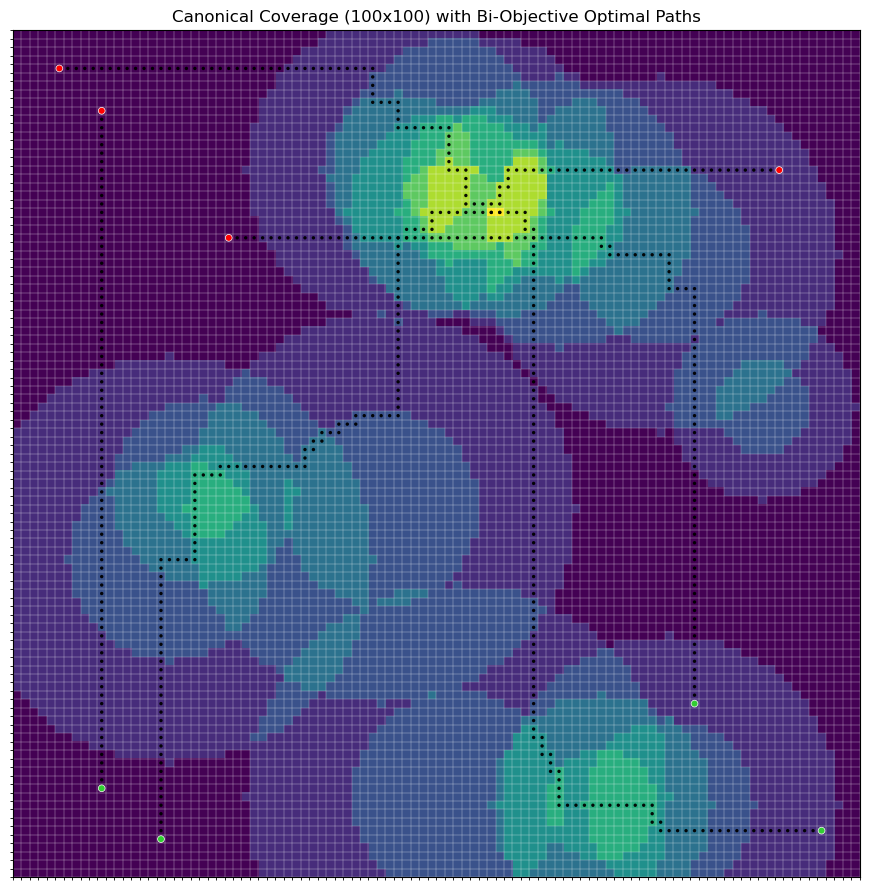

In [8]:
# Full working script: builds coverage from fixed satellites, computes bi-objective optimal
# paths for people (min steps, then max points), and plots paths as circles on the heat map.
# Only the final plot is produced (no intermediate helper image).

from typing import List, Tuple
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# ----------------------------
# Data types
Satellite = Tuple[Tuple[int, int], int]                 # ((row, col), radius)
Person = Tuple[Tuple[int, int], Tuple[int, int]]        # (start_rc, end_rc)

# ----------------------------
# Canonical satellites (fixed, no RNG)
SATELLITES: List[Satellite] = [
    ((8, 77), 20),
    ((43, 43), 23),
    ((8, 69), 13),
    ((9, 52), 25),
    ((73, 76), 21),
    ((78, 51), 12),
    ((83, 45), 18),
    ((37, 18), 24),
    ((78, 64), 16),
    ((82, 54), 17),
    ((45, 22), 11),
    ((55, 88), 11),
]

# ----------------------------
# Build additive coverage grid: +2 inside inner half-radius, +1 in outer ring
def build_coverage(satellites: List[Satellite], rows: int = 100, cols: int = 100) -> np.ndarray:
    C = np.zeros((rows, cols), dtype=np.int32)
    for (tr, tc), R in satellites:
        r0, r1 = max(0, tr - R), min(rows - 1, tr + R)
        c0, c1 = max(0, tc - R), min(cols - 1, tc + R)
        halfR2 = (0.5 * R) ** 2
        R2 = R * R
        for r in range(r0, r1 + 1):
            dr2 = (r - tr) * (r - tr)
            for c in range(c0, c1 + 1):
                d2 = dr2 + (c - tc) * (c - tc)
                if d2 <= R2:
                    C[r, c] += 1
                    if d2 <= halfR2:
                        C[r, c] += 1
    return C

# ----------------------------
# Bi-objective path: minimize steps; among shortest, maximize collected coverage points
def optimal_path(grid: np.ndarray, start: Tuple[int,int], end: Tuple[int,int]) -> Tuple[int,int,List[Tuple[int,int]]]:
    rows, cols = grid.shape
    inb = lambda r, c: 0 <= r < rows and 0 <= c < cols

    # best[r][c] = (min_dist, max_points_for_that_min_dist)
    best = [[None] * cols for _ in range(rows)]
    best[start[0]][start[1]] = (0, int(grid[start[0], start[1]]))

    q = deque([(start[0], start[1], 0, int(grid[start[0], start[1]]), [start])])

    best_path = None
    best_points = -1

    while q:
        r, c, dist, pts, path = q.popleft()

        if (r, c) == end:
            # First by shortest distance, then by max points
            if (best_path is None
                or dist < len(best_path) - 1
                or (dist == len(best_path) - 1 and pts > best_points)):
                best_path = path
                best_points = pts
            continue

        for nr, nc in ((r+1, c), (r-1, c), (r, c+1), (r, c-1)):
            if inb(nr, nc):
                new_dist = dist + 1
                new_pts = pts + int(grid[nr, nc])
                cur = best[nr][nc]
                if cur is None or new_dist < cur[0] or (new_dist == cur[0] and new_pts > cur[1]):
                    best[nr][nc] = (new_dist, new_pts)
                    q.append((nr, nc, new_dist, new_pts, path + [(nr, nc)]))

    return (len(best_path) - 1, best_points, best_path) if best_path else (-1, -1, [])

# ----------------------------
# People (start -> end)
PEOPLE: List[Person] = [
    ((4, 17), (83, 90)),
    ((10, 10), (90, 10)),
    ((20, 80), (75, 25)),
    ((5, 95), (95, 5)),
]

# ----------------------------
# Plot heat map + paths:
#   - Start cell: green circle (fits inside cell)
#   - End cell: red circle (fits inside cell)
#   - Path cells: smaller colored dots along the route
def plot_people_paths(C: np.ndarray, people: List[Person], title: str) -> None:
    rows, cols = C.shape
    fig, ax = plt.subplots(figsize=(9, 9))

    # Heat map
    ax.imshow(C, origin='lower', interpolation='nearest')

    # Thin white grid lines
    ax.set_xticks(np.arange(-0.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, rows, 1), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=0.2)
    ax.set_xticks([]); ax.set_yticks([])

    # Circle sizes
    r_start_end = 0.4   # start/end markers
    r_path = 0.2        # path dots

    # Distinct colors per person
    path_colors = ["black"]

    for i, (start, end) in enumerate(people):
        steps, points, path = optimal_path(C, start, end)

        # path circles (skip ends to avoid overlap with larger markers)
        color = path_colors[i % len(path_colors)]
        for (rr, cc) in (path[1:-1] if path and len(path) > 2 else []):
            ax.add_patch(Circle((cc, rr), r_path, facecolor=color, edgecolor="none", alpha=0.95))

        # start (green) and end (red)
        ax.add_patch(Circle((start[1], start[0]), r_start_end, facecolor="limegreen", edgecolor="white", linewidth=0.5))
        ax.add_patch(Circle((end[1], end[0]),   r_start_end, facecolor="red",       edgecolor="white", linewidth=0.5))

        # Optional: print summary in console
        print(f"Person {i+1}: {start} -> {end} | steps={steps}, points={points}")

    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# ----------------------------
# Build coverage and render final plot (only this plot; no helper/extra images)
C = build_coverage(SATELLITES, rows=100, cols=100)
plot_people_paths(C, PEOPLE, title="Canonical Coverage (100x100) with Bi-Objective Optimal Paths")


# Full Scale Buildout

In [6]:
# Multi-agent, multi-objective BFS on a 100x100 grid with additive “coverage points”.
# - Single-agent search: minimize steps; among shortest, maximize points collected.
# - Multi-agent coordination: radius-10 sensing disks must NOT overlap at any time step.
#   We plan agents in priority order using a time-expanded BFS with a reservation table.
# - Framework: plug-in dominance/objective so you can add metrics (fuel, risk, rewards) later.

from typing import List, Tuple, Dict, Callable, Optional
from collections import deque, defaultdict
import numpy as np

# ----------------------------
# Types
RC        = Tuple[int, int]
Satellite = Tuple[RC, int]
Person    = Tuple[RC, RC]

# ----------------------------
# Fixed satellites (no RNG) for coverage construction (+2 inner half-radius, +1 outer ring)
SATELLITES: List[Satellite] = [
    ((8, 77), 20),
    ((43, 43), 23),
    ((8, 69), 13),
    ((9, 52), 25),
    ((73, 76), 21),
    ((78, 51), 12),
    ((83, 45), 18),
    ((37, 18), 24),
    ((78, 64), 16),
    ((82, 54), 17),
    ((45, 22), 11),
    ((55, 88), 11),
]

def build_coverage(satellites: List[Satellite], rows: int = 100, cols: int = 100) -> np.ndarray:
    """Additive coverage field: +2 inside R/2, +1 inside R."""
    C = np.zeros((rows, cols), dtype=np.int32)
    for (tr, tc), R in satellites:
        r0, r1 = max(0, tr - R), min(rows-1, tr + R)
        c0, c1 = max(0, tc - R), min(cols-1, tc + R)
        R2 = R * R
        halfR2 = (0.5 * R) ** 2
        for r in range(r0, r1+1):
            dr2 = (r - tr) * (r - tr)
            for c in range(c0, c1+1):
                d2 = dr2 + (c - tc) * (c - tc)
                if d2 <= R2:
                    C[r, c] += 1
                    if d2 <= halfR2:
                        C[r, c] += 1
    return C

# Build canonical coverage
C = build_coverage(SATELLITES, 100, 100)

# ----------------------------
# Multi-objective BFS framework (single agent, time-expanded when needed)

class MultiObjectiveBFS:
    """
    General BFS with dominance: we keep a Pareto-optimal frontier per state key.
    - state: any hashable (e.g., (r,c) or (r,c,t))
    - neighbor_fn(state) -> iterable of (next_state, step_cost, reward_dict)
    - dom_key(accum) -> tuple/list used for dominance compare
    - better(a, b) -> True if a dominates b (strictly better in at least one metric and no worse in others)
    """
    def __init__(
        self,
        start_state,
        is_goal: Callable[[object], bool],
        neighbor_fn: Callable[[object], List[Tuple[object, int, Dict[str, int]]]],
        dom_key: Callable[[Dict[str, int]], Tuple],
        better: Callable[[Tuple, Tuple], bool],
        state_key: Callable[[object], object] = lambda s: s,
        max_expansions: int = 2_000_000
    ):
        self.start_state  = start_state
        self.is_goal      = is_goal
        self.neighbor_fn  = neighbor_fn
        self.dom_key      = dom_key
        self.better       = better
        self.state_key    = state_key
        self.max_exp      = max_expansions

    def run(self, accum0: Optional[Dict[str, int]] = None):
        if accum0 is None:
            accum0 = {}
        # Frontier and parent pointers
        q = deque()
        q.append((self.start_state, accum0, None))  # (state, accum_metrics, parent_idx)
        parents: List[Tuple[Optional[int], object]] = [(-1, self.start_state)]
        par_idx_map: Dict[object, int] = {self.start_state: 0}

        # For each state_key, maintain a list of non-dominated dom_keys (Pareto frontier)
        frontier: Dict[object, List[Tuple]] = defaultdict(list)
        frontier[self.state_key(self.start_state)].append(self.dom_key(accum0))

        expansions = 0
        best_goal = None  # (dom_key, parent_pointer_index)

        while q and expansions < self.max_exp:
            state, accum, parent_idx = q.popleft()
            expansions += 1

            if self.is_goal(state):
                dk = self.dom_key(accum)
                if best_goal is None or self.better(dk, best_goal[0]):
                    best_goal = (dk, par_idx_map[state])
                # continue BFS to possibly find same-length but better reward if desired
                # (BFS level-order ensures minimal steps in unweighted time-expanded graphs)

            for nxt, step_cost, reward in self.neighbor_fn(state):
                # accumulate metrics
                accum_next = accum.copy()
                for k, v in reward.items():
                    accum_next[k] = accum_next.get(k, 0) + v

                skey = self.state_key(nxt)
                dk_next = self.dom_key(accum_next)

                # dominance check vs existing frontier at this state key
                dominated = False
                # prune existing dominated entries; if nxt dominates some, we can replace
                keep: List[Tuple] = []
                for dk in frontier.get(skey, []):
                    if self.better(dk, dk_next):   # existing strictly better -> we discard nxt
                        dominated = True
                        keep.append(dk)
                    elif self.better(dk_next, dk): # new strictly better -> drop the old one
                        continue
                    else:
                        keep.append(dk)
                if dominated:
                    continue

                # Accept nxt; update frontier set
                frontier[skey] = keep + [dk_next]

                # parent bookkeeping
                if nxt not in par_idx_map:
                    parents.append((par_idx_map[state], nxt))
                    par_idx_map[nxt] = len(parents) - 1

                q.append((nxt, accum_next, par_idx_map[state]))

        # Reconstruct best goal path if found
        path_states = []
        if best_goal is not None:
            idx = best_goal[1]
            while idx != -1:
                parent_idx, s = parents[idx]
                path_states.append(s)
                idx = parent_idx
            path_states.reverse()
            return path_states, best_goal[0]
        return [], None

# ----------------------------
# Single-agent neighbor generator (time-expanded), honoring a reservation table
# Reservation table: dict[t] -> list of forbidden disks: (center_rc, radius)
# Constraint: agent position at time t must be distance >= sum of radii from all forbidden centers at t.

def manhattan_neighbors(r: int, c: int) -> List[RC]:
    return [(r+1,c), (r-1,c), (r,c+1), (r,c-1), (r,c)]  # include WAIT (stay)

def in_bounds(r: int, c: int, rows: int, cols: int) -> bool:
    return 0 <= r < rows and 0 <= c < cols

def allowed_position(rc: RC, t: int, reservations: Dict[int, List[Tuple[RC, int]]]) -> bool:
    """Check disk non-overlap constraints at time t: dist(center) >= r1+r2."""
    if t not in reservations:
        return True
    r, c = rc
    for (cr, cc), rad in reservations[t]:
        # Euclidean distance squared vs threshold squared
        dr = r - cr
        dc = c - cc
        if (dr*dr + dc*dc) < (rad * rad):  # strictly less than (r1+r2)^2 violates; we use < to forbid touching overlap
            return False
    return True

def single_agent_neighbors_factory(
    grid: np.ndarray,
    rows: int,
    cols: int,
    reservations: Dict[int, List[Tuple[RC, int]]],
    sense_radius: int = 10
) -> Callable[[Tuple[int,int,int]], List[Tuple[Tuple[int,int,int], int, Dict[str,int]]]]:
    """
    State = (r,c,t). Each step increments t by 1.
    Rewards:
      - 'steps': +1 each move (for dominance on minimal steps)
      - 'points': +grid[nr,nc] when moving/ waiting (you can adjust if waiting shouldn't re-collect points)
    """
    def neighbors(state: Tuple[int,int,int]):
        r, c, t = state
        out = []
        for nr, nc in manhattan_neighbors(r, c):
            if in_bounds(nr, nc, rows, cols):
                nt = t + 1
                # Enforce non-overlap at the NEXT time (everyone moves synchronously per tick)
                if allowed_position((nr, nc), nt, reservations):
                    out.append(((nr, nc, nt), 1, {'steps': 1, 'points': int(grid[nr, nc])}))
        return out
    return neighbors

# ----------------------------
# Dominance policy for “min steps, max points”
# We use dom_key(accum) = (steps, -points)  -> lexicographic minimal
# better(a, b) returns True if a strictly better lexicographically than b

def dom_key_steps_points(accum: Dict[str,int]) -> Tuple[int, int]:
    steps = accum.get('steps', 0)
    pts   = accum.get('points', 0)
    return (steps, -pts)

def better_lex_min(a: Tuple[int,int], b: Tuple[int,int]) -> bool:
    return a < b  # Python tuple compare is lexicographic

# ----------------------------
# Cooperative (prioritized) planning with disk non-overlap
# - Plan agents in order 0..N-1
# - Each agent uses time-expanded BFS with reservations of previous agents
# - Reservation at time t contains (pos_of_planned_agent_at_t, radius_sum^2 threshold).
#   Because all agents have same sensing radius R=10, we forbid positions within distance < 20.
#   For simplicity, we forbid any other agent within radius 20: we encode as radius^2 = (2R)^2 = 400.

def plan_agent(
    grid: np.ndarray,
    start: RC,
    goal: RC,
    reservations: Dict[int, List[Tuple[RC, int]]],
    max_time: int = 1000,
    sense_radius: int = 10
):
    rows, cols = grid.shape
    # Start state (r,c,t=0) must also be allowed at t=0
    if not allowed_position(start, 0, reservations):
        return [], None

    nbrs = single_agent_neighbors_factory(grid, rows, cols, reservations, sense_radius)

    def is_goal(state):
        r, c, t = state
        return (r, c) == goal or t >= max_time

    bfs = MultiObjectiveBFS(
        start_state = (start[0], start[1], 0),
        is_goal     = is_goal,
        neighbor_fn = nbrs,
        dom_key     = dom_key_steps_points,
        better      = better_lex_min,
        state_key   = lambda s: s,  # full (r,c,t) as state key
        max_expansions = 5_000_000
    )
    path_states, dom = bfs.run(accum0={'steps': 0, 'points': int(grid[start[0], start[1]])})
    # Trim path to stop at goal if we overshot due to max_time
    if path_states:
        # Ensure we end exactly at goal if reachable
        for i, (_, _, t) in enumerate(path_states):
            if (path_states[i][0], path_states[i][1]) == goal:
                path_states = path_states[:i+1]
                break
    return path_states, dom

def build_reservations_from_paths(paths: List[List[Tuple[int,int,int]]], sense_radius: int = 10) -> Dict[int, List[Tuple[RC, int]]]:
    """Turn existing agent paths into time-indexed forbidden disks for future agents."""
    res: Dict[int, List[Tuple[RC, int]]] = defaultdict(list)
    # forbid centers within 2R -> threshold radius = 2R; we store squared threshold inside allowed_position
    # To exploit allowed_position's check, we pass radius = 2R and compare with < rad^2 inside that function.
    twoR = 2 * sense_radius
    twoR2 = twoR * twoR
    for path in paths:
        for (r, c, t) in path:
            res[t].append(((r, c), twoR2))
        # Keep agent parked at its goal after arrival to avoid others overlapping later times
        if path:
            gr, gc, gt = path[-1]
            for t in range(gt+1, gt+201):
                res[t].append(((gr, gc), twoR2))
    return res

def plan_all_agents(
    grid: np.ndarray,
    people: List[Person],
    sense_radius: int = 10,
    max_time: int = 1000
):
    """Prioritized planning: sequentially plan agents with non-overlap disk constraints."""
    all_paths: List[List[Tuple[int,int,int]]] = []
    reservations: Dict[int, List[Tuple[RC, int]]] = defaultdict(list)

    for idx, (start, goal) in enumerate(people):
        # Build reservations from previously planned agents
        reservations = build_reservations_from_paths(all_paths, sense_radius)
        path, dom = plan_agent(grid, start, goal, reservations, max_time=max_time, sense_radius=sense_radius)
        if not path:
            print(f"[Agent {idx+1}] No feasible path under non-overlap constraints.")
            all_paths.append([])
            continue
        all_paths.append(path)
        steps = len(path) - 1 if path else -1
        points = None
        if dom is not None:
            steps_from_dom, neg_pts = dom
            points = -neg_pts
        print(f"[Agent {idx+1}] {start} -> {goal} | steps={steps}, points={points}, end_time={path[-1][2] if path else 'NA'}")
    return all_paths

# ----------------------------
# Example PEOPLE and run
PEOPLE: List[Person] = [
    ((4, 17), (83, 90)),
    ((10, 10), (90, 10)),
    ((20, 80), (75, 25)),
    ((5, 95), (95, 5)),
]

# Plan all agents with non-overlapping radius-10 disks at each synchronized time step
all_paths = plan_all_agents(C, PEOPLE, sense_radius=10, max_time=800)

# `all_paths` contains per-agent lists of (r, c, t) states satisfying:
#  - minimal steps (BFS) given prior agents' reservations,
#  - among shortest, maximal collected coverage points,
#  - disk non-overlap (radius=10) with earlier agents at every time t (including waits),
#  - agents “park” at their goal so later agents cannot violate the constraint after arrival.

# ----------------------------
# Notes:
# - To customize objectives, swap:
#     dom_key = dom_key_steps_points
#     better  = better_lex_min
#   with your own, e.g., dom_key(accum) -> (steps, -points, fuel, risk, ...)
# - To change reward accounting (e.g., don’t gain points on WAIT), edit neighbor_fn to set points=0 when (nr,nc)==(r,c).
# - To change tie-breaking priority among agents, reorder PEOPLE.
# - For stricter collision models, add “edge-swap” checks (forbid two agents swapping positions at same t).

KeyboardInterrupt: 

# Seperated Parts

A) Compute coverage on a grid (sum of decays), then answer path coverage

In [ ]:
from typing import List, Tuple
import math

def coverage_grid(rows: int, cols: int, towers: List[Tuple[int,int,float]],
                  lam: float = 0.1, cutoff: float = 50.0) -> List[List[float]]:
    """
    towers: list of (r, c, w) where w is tower strength
    f(d) = w * exp(-lam * d); ignore towers beyond cutoff to save time
    """
    C = [[0.0]*cols for _ in range(rows)]
    cutoff2 = cutoff * cutoff
    for tr, tc, w in towers:
        r0, r1 = max(0, int(tr - cutoff)), min(rows-1, int(tr + cutoff))
        c0, c1 = max(0, int(tc - cutoff)), min(cols-1, int(tc + cutoff))
        for r in range(r0, r1+1):
            dr2 = (r - tr)*(r - tr)
            for c in range(c0, c1+1):
                d2 = dr2 + (c - tc)*(c - tc)
                if d2 <= cutoff2:
                    d = math.sqrt(d2)
                    C[r][c] += w * math.exp(-lam * d)
    return C

def path_min_avg_coverage(C: List[List[float]], path_cells: List[Tuple[int,int]]):
    vals = [C[r][c] for r, c in path_cells]
    return (min(vals), sum(vals)/len(vals))


B) Widest path (maximize minimum coverage along path)

In [ ]:
import heapq

def widest_path(C: List[List[float]], s: Tuple[int,int], t: Tuple[int,int]) -> float:
    rows, cols = len(C), len(C[0])
    inb = lambda r,c: 0 <= r < rows and 0 <= c < cols
    best = [[-1.0]*cols for _ in range(rows)]               # best bottleneck so far
    pq = [(-C[s[0]][s[1]], s)]                              # max-heap via negative
    best[s[0]][s[1]] = C[s[0]][s[1]]
    while pq:
        neg_bott, (r,c) = heapq.heappop(pq)
        bott = -neg_bott
        if (r,c) == t:
            return bott                                     # max-min achieved
        if bott < best[r][c]: 
            continue
        for nr, nc in ((r+1,c),(r-1,c),(r,c+1),(r,c-1)):
            if inb(nr,nc):
                cand = min(bott, C[nr][nc])                 # bottleneck relax
                if cand > best[nr][nc]:
                    best[nr][nc] = cand
                    heapq.heappush(pq, (-cand, (nr,nc)))
    return 0.0


C) Coverage islands (BFS)

In [ ]:
from collections import deque

def count_coverage_islands(C: List[List[float]], tau: float) -> int:
    rows, cols = len(C), len(C[0])
    seen = [[False]*cols for _ in range(rows)]
    def bfs(sr, sc):
        q = deque([(sr, sc)]); seen[sr][sc] = True
        while q:
            r,c = q.popleft()
            for nr, nc in ((r+1,c),(r-1,c),(r,c+1),(r,c-1)):
                if 0 <= nr < rows and 0 <= nc < cols and not seen[nr][nc] and C[nr][nc] >= tau:
                    seen[nr][nc] = True
                    q.append((nr, nc))
    islands = 0
    for r in range(rows):
        for c in range(cols):
            if C[r][c] >= tau and not seen[r][c]:
                bfs(r,c)
                islands += 1
    return islands
